# Data Analysis & Visualizations: celebrity deaths from 2006 to 2016

Today we'll explore quite a positive dataset - Celebrity Deaths from 2006 to 2016. 
To make it less tragic, I am going to use two beautiful ggplot2 color palettes; plus all data manipulation will be created using amazing dplyr package.

During the second part of the analysis, I will share a great alternative way to visualize missing values using ggplot (credits to Nicholas Tierney).

Part three will include and reasons why we should not ignore missing values in this dataset.

## Plan of action
1. Overview and "death dynamics".
2. Missing data.
3. The most frequent cause of death: false conclusions?


## 1. Overview and "death dynamics"

In [8]:
# loading packages
library(pacman)
p_load(dplyr, stringr, reshape2, ggplot2, sqldf, extrafont, wesanderson)

#importing dataset
deathSet <- read.csv("C:/Users/Elena/Downloads/celebrity_deaths_4.csv/celebrity_deaths_4.csv", 
                     na.strings = c("", "NA"), stringsAsFactors = F) %>% tbl_df 

# first look
head(deathSet)
str(deathSet)

age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score
85,1921,natural causes,January,2006,businessman chairman of IBM (1973‰ÛÒ1981),Frank Cary,American,1
49,1957,murdered,January,2006,musician (House of Freaks Gutterball),Bryan Harvey,American,2
64,1942,Alzheimer's disease,January,2006,baseball player (Oakland Athletics),Paul Lindblad,American,1
86,1920,Alzheimer's disease,January,2006,politician Representative from Oregon (1957‰ÛÒ1961),Charles O. Porter,American,2
82,1924,cancer,January,2006,nightclub owner (Tropicana Club),Ofelia Fox,Cuban,NA
52,1954,stroke,January,2006,New Guinean politician Prime Minister (1997‰ÛÒ1999),Sir William Skate,Papua,NA


Classes 'tbl_df', 'tbl' and 'data.frame':	21458 obs. of  9 variables:
 $ age           : int  85 49 64 86 82 52 31 31 55 70 ...
 $ birth_year    : int  1921 1957 1942 1920 1924 1954 1975 1975 1951 1936 ...
 $ cause_of_death: chr  " natural causes" " murdered" " Alzheimer's disease" " Alzheimer's disease" ...
 $ death_month   : chr  "January" "January" "January" "January" ...
 $ death_year    : int  2006 2006 2006 2006 2006 2006 2006 2006 2006 2006 ...
 $ famous_for    : chr  " businessman chairman of IBM (1973ÛÒ1981)" " musician (House of Freaks Gutterball)" " baseball player (Oakland Athletics)" " politician Representative from Oregon (1957ÛÒ1961)" ...
 $ name          : chr  "Frank Cary" "Bryan Harvey" "Paul Lindblad" "Charles O. Porter" ...
 $ nationality   : chr  "American" "American" "American" "American" ...
 $ fame_score    : int  1 2 1 2 NA NA 1 4 2 NA ...


In this first part, we are going to create bins for three key features and analyze resulting distributions while mixing them together.

#### Key feature: death causes

Ten categories should be enough here:
- cancer
- natural death
- murder
- Alzheimer or Parkinson (both have a late onset in person's life)
- heart (includes heart attack/failure and cardiac arrest)
- suicide
- accident
- other

We also leave missing values as they are.

In [9]:
# sql solution  
deathSet <- sqldf("SELECT *,
CASE 
  WHEN cause_of_death LIKE '%cancer%' OR 'leukemia' THEN 'cancer'
  WHEN cause_of_death LIKE 'natural' OR '%sleep%' OR '%health%' THEN 'natural death' 
  WHEN cause_of_death LIKE '%murder%' OR 'shot' THEN 'murder'
  WHEN cause_of_death LIKE '%Alzheimer%' OR '%Parkinson%' THEN 'Alzheimer or Parkinson'
  WHEN cause_of_death LIKE '%heart%' OR '%stroke%' OR '%cardiac%' THEN 'heart'
  WHEN cause_of_death LIKE '%suicide%' THEN 'suicide'
  WHEN cause_of_death LIKE '%pneumonia%' OR '%respiratory%' THEN 'pneumonia'
  WHEN cause_of_death LIKE '%crash%' OR '%accident%' OR '%fall%' OR '%collision%' OR '%car%' THEN 'accident'
  WHEN cause_of_death IS NULL THEN NULL
ELSE 'other' END AS cause_group
FROM deathSet")

deathSet$cause_group <- factor(deathSet$cause_group)

Let's now plot the distribution of cause of death for the given period:

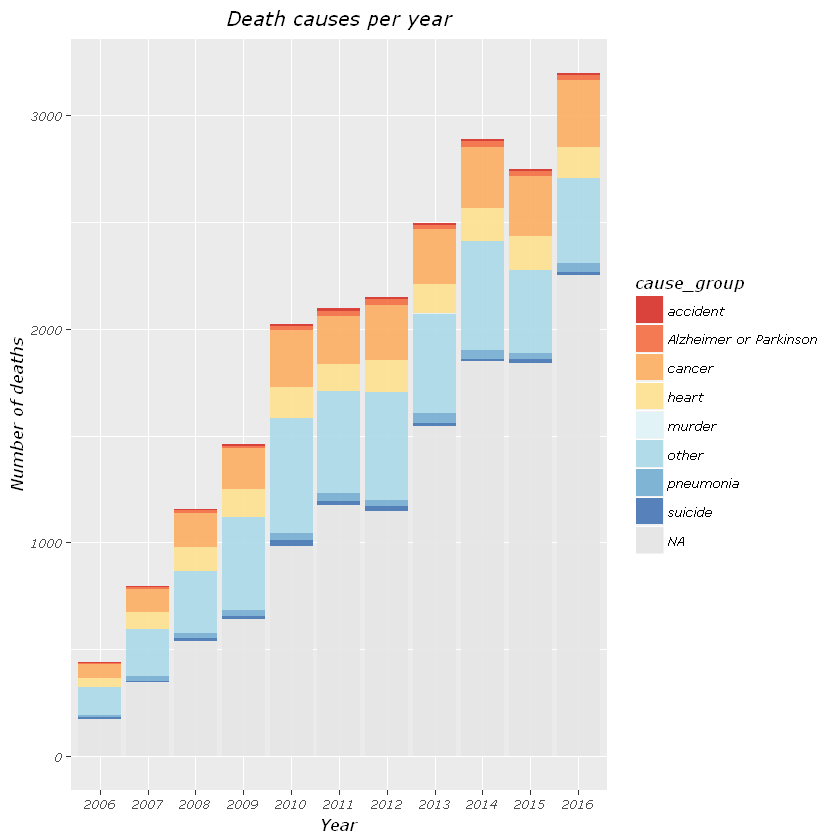

In [10]:
# text theme for every plot in this project
text_theme <- theme(text = element_text(size = 10, 
                            family = "Verdana", 
                            face = "italic"),
                  plot.title = element_text(hjust = 0.5))

# color theme
color_theme <- scale_fill_brewer(palette = "RdYlBu", 
                                 na.value = "grey90")
                                  
deathSet$death_year <- factor(deathSet$death_year)

ggplot(deathSet, aes(x = death_year)) +
  geom_bar(aes(fill = cause_group), 
           position = "stack",
           alpha = 0.9) +
  text_theme +
  color_theme +
  labs(title = "Death causes per year", 
       x = "Year", 
       y = "Number of deaths")

We can be sure about at least three things here:

First, there is a positive trend in celebrities' deaths, which went up from around 500 records at the end of 2006 to more than 3000 in 2016.

Below is the exact number of celebrity deaths per year, if interested:

In [11]:
count(deathSet, death_year)

death_year,n
2006,440
2007,797
2008,1157
2009,1459
2010,2023
2011,2096
2012,2151
2013,2496
2014,2891
2015,2750


Notice that the number of records from 2010 to 2012 do not change much: the 3 year difference is equal to 128 records. This is very low compared to the previous period, from 2009 to 2010, where there was an increase of nearly 600 deaths in a single year.

Second, the amount of missing data obviously also increased over time. We can see that by looking at light-grey bars.

Lastly, cancer seems to be the dominant known cause of death. Meanwhile, death by natural causes doesn't really show up in the last two years (2015 and 2016). Apparently, there were too many other ways to end the journey.

#### Key variable: fame score

It's always a good idea to first check the distribution:

In [12]:
summary(deathSet$fame_score)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   2.000   4.000   8.624   8.000 695.000    1606 

Let's convert NA's into the median values (not into the mean as it was pulled up by max value) and plot fame scores.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


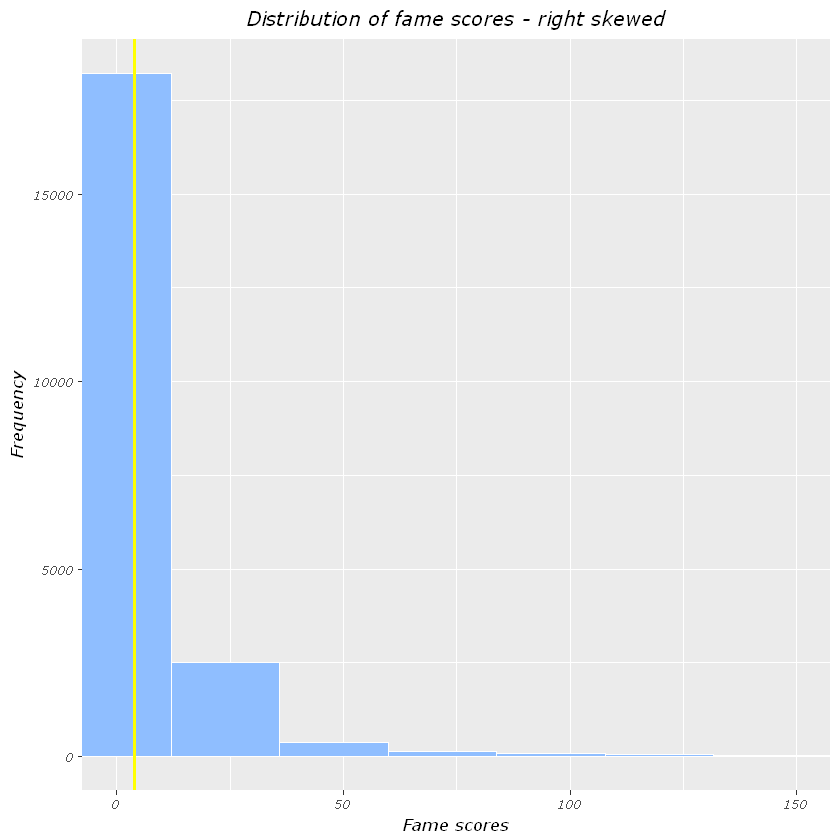

In [13]:
# convert NA's into median value
deathSet$fame_score[is.na(deathSet$fame_score)] <- median(deathSet$fame_score,
                                                          na.rm = TRUE)
# distribution of fame scores 
ggplot(deathSet, 
       aes(x = fame_score)) + 
  geom_histogram(fill = "#8fbeff", 
                 col = "white") +
  geom_vline(aes(xintercept = median(deathSet$fame_score)), 
             col = "yellow",
             size = 1) +
  labs(title = "Distribution of fame scores - right skewed",
       x = "Fame scores",
       y = "Frequency") +
  coord_cartesian(xlim = c(0, 150)) +
  text_theme

We could divide famous scores into 3 categories:
- locally famous (below median)
- famous (median and higher)
- worldwide famous (two times median and higher)

Let's do that:

In [14]:
# create bins < 5409, < 10818 and 10818 >
deathSet$fame_group <- factor(findInterval(deathSet$fame_score, 
                                          c(0, 4, 8)))
# assigning corresponding names
levels(deathSet$fame_group) <- c("locally famous", "famous", "worldwide famous")

By the way, you are welcome to suggest your threshold for the classifier. This was just one way of doing it.

Finally, let's check the composition of the fame_group column:

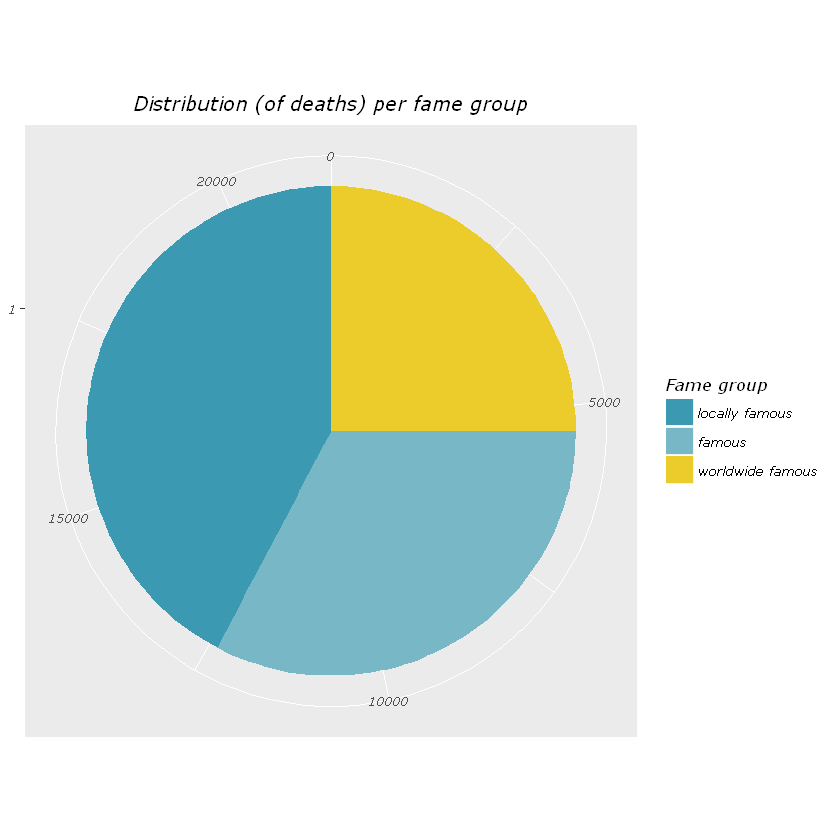

In [15]:
# these palettes com from great wesanderson package
color_theme2 <- scale_fill_manual(values = wes_palette(n = 3, 
                                                       name = "Zissou"))
ggplot(deathSet, 
       aes(x = factor(1), 
           fill = fame_group)) +
  geom_bar(width = 3) +
  coord_polar(theta = "y") +
  labs(fill= "Fame group") +
  color_theme2 +
  labs(title = "Distribution (of deaths) per fame group",
       x = NULL,
       y = NULL) +
  text_theme

As we can see, the majority of celebrities who died during these last ten years were locally famous.

#### Key feature: celebrity age

As always, let's check numbers first:

In [16]:
summary(deathSet$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0      68      80      76      87     125 

Well, that's not right. Let's create age bins in order to manage ages a bit easier and sort non-relevant data:

In [17]:
# convert non relevant data into NA's
deathSet$age[deathSet$age > 109 | deathSet$age < 20] <- NA

# create bins [20, 40), [40, 60) and so on
# last bin will be a bit bigger [80, 110) to make it more realistic
deathSet$age_group <- factor(findInterval(deathSet$age, 
                                          c(20, 40, 60, 80, 110)))

# "unknown" for those who were < 20 and 100 >=
levels(deathSet$age_group) <- c("20-39", "40-59", "60-79", "80-109")

Let's see how fame groups are distributed per age categories:

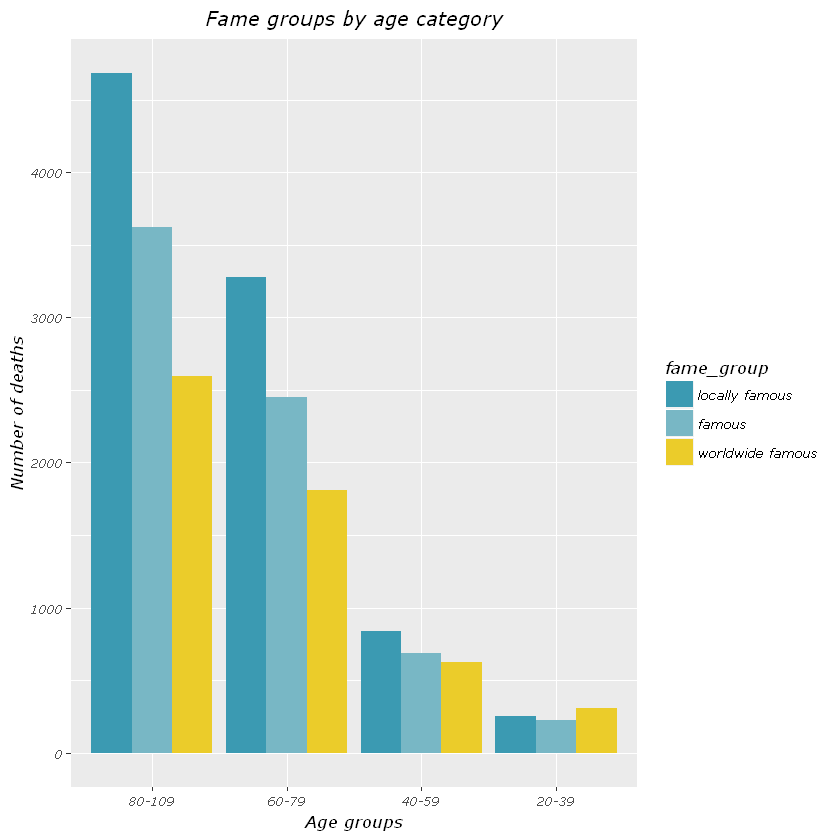

In [18]:
# creating a "clean" plot by removing NA's bar
ggplot(subset(deathSet, !is.na(age_group)), 
       aes(x = reorder(age_group,
                       age_group,
                       function(x) -length(x)))) +
  geom_bar(aes(fill = fame_group),
           position = "dodge") +
  text_theme +
  color_theme2 +
  labs(title = "Fame groups by age category", 
       x = "Age groups", 
       y = "Number of deaths")

As we saw before locally famous people represent the majority, but in this case, they also lead almost each age category. This exception is the age category of 20-39 where the leading group is "worldwide famous" celebrities.

Let's take only the worldwide famous group and compare two different age categories in it, below and above 60, by plotting death causes over the given period of time:

In [ ]:
# death causes for worldwide famous aged 60+
ggplot(deathSet %>% filter(fame_group == "worldwide famous" & age_group == c("60-79", "80-99")), 
       aes(x = death_year)) +
  geom_bar(aes(fill = cause_group), 
           stat = "count") +
  text_theme +
  color_theme +
  labs(title = "Worldwide famous: death causes above 60", 
       x = "Age group", 
       y = "Number of deaths") 

# death causes for worldwide famous for < 60
ggplot(deathSet %>% filter(fame_group == "worldwide famous" & age_group == c("20-39", "40-59")), 
       aes(x = death_year)) +
  geom_bar(aes(fill = cause_group), 
           stat = "count") +
  text_theme +
  color_theme +
  labs(title = "Worldwide famous: death causes below 60", 
       x = "Age group", 
       y = "Number of deaths") +
  coord_cartesian(ylim = c(0, 180))

Notice that I have created two plots on the same scale to avoid any misunderstanding.
Worldwide celebrities under the age of 60 do not seem to have Alzheimer's/Parkinson's disease, this category is not even present, as both illnesses are age-related. On the other hand, suicides (years 2010 and 2011 particularly) are more prevalent for this age category.

As for the celebrities at the age of above 60, we notice that accidents have two "popular" years - 2012 and 2014. And 2016 year is remarkable by the high rate of deaths from pneumonia, comparing to precedent years.

For both plots, cancer and heart diseases are clear leaders. Though I would avoid concluding which of these causes is the main one.

Below is quite an obvious plot, but it will make a great transition to the last part of this analysis.

In [ ]:
ggplot(subset(deathSet, !is.na(age_group)), 
       aes(x = reorder(age_group,
                       age_group,
                       function(x) -length(x)))) +
  geom_bar(aes(fill = cause_group), 
           stat = "count") +
  text_theme +
  color_theme +
  labs(title = "Too old to be alive", 
       x = "Age group", 
       y = "Number of deaths")

The majority of deaths happens at senior ages (at 60 +), which is not a surprise.

What is interesting, though, is that we miss almost twice as much information about death causes for celebrities aged 80+ than for the 60-79 group. Notice that both are almost of the same size.

Natural death and death from Alzheimer's/Parkinson's disease become more of a reality for elder celebrities aged 80-99, which is logical too.
We also notice, that cancer seems to be a bigger problem for "early" seniors (age 60-79) than for other groups.

### 2. Missing data

As we have noticed before we lack quite a lot of data on the cause of death, but how much are we missing? There is a good alternative for Amelia missmap function suggested by Nicholas Tierney. I share his code below.

In [ ]:
ggplot_missing <- function(x) {
  x %>% 
    is.na %>%
    melt %>%
    ggplot(data = .,
           aes(x = Var2,
               y = Var1)) +
    geom_raster(aes(fill = value)) +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme_minimal() + 
    theme(axis.text.x  = element_text(angle = 45, vjust = 0.5)) + 
    labs(x = "Variables in Dataset",
         y = "Rows / observations")
}

ggplot_missing(deathSet %>% 
                 select(-cause_of_death, -fame_score, -age))

Wow! Apparently, more than 3/4 of the cause of death data is missing, which unfortunately might lead us to wrong conclusions.

### 3. The most frequent cause of death: false conclusions?

Suppose we want to know the most frequent cause of celebrity death for the given period:

In [ ]:
ggplot(deathSet, aes(x = reorder(cause_group, 
                                 cause_group, 
                                 function(x) length(x)))) +
  geom_bar(aes(fill = cause_group), 
           stat = "count") +
  text_theme +
  color_theme +
  labs(title = "Cancer - the leading cause of death? ", 
       x = "Causes of death", 
       y = "Number of deaths") +
  coord_flip() +
  guides(fill = F)

Even though the "cancer" seems to be a leader among known causes, we can not be sure that it is true in reality. It could not be a good idea to rush into conclusions, mostly for such a sensitive topic.

We might not know (for now at least) if some information was hidden on purpose or it was a mis-crawled information, which is very possible, but let's suppose that at least 1/4 of missing data contains heart disease. In this case, the second most common cause easily takes the first place instead.

Some may argue about remaining data that we have: it is still big enough to be indicative of the whole cause of death picture. But personally, I would not want to place a shadow on other death causes by highlighting the most frequent one.

In order to obtain some certainty, we could try to improve the classifier of each category, minimizing the 'other' group. But again we would be left with a huge amount of missing data.

So am I saying that we can not conclude anything, given this large amount of missing data? Of course not. We usually base an analysis on subsets of population. Otherwise, it would be simply unmanageable. The main point here, I think, is to examine every possibility, before jumping to conclusions.

Datageekette